## FIRST PREDICTION MODEL: LINEAR REGRESSION

necessary steps: 
* Step 1: data cleaning and NAs removal or imputing (already done)
* Step 2: encoding of categorical variables (or dummies) and standardization of numerical variables (pay attention to exclude the target variable ('Trip_Price')
* Step 3: split the dataset into train and test 
* Step 4: fit the model on the training set and evaluate its performance on the test set
* Step 5: evalaute some techniques to improve the performance of the linear regression

In [945]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import numpy as np

In [956]:
path = '/Users/francescavasta/Desktop/ADSEM/II YEAR I SEM/UE 2 - Machine Learning /Machine Learning - TAXI PROJECT/data_clean.csv'
df_original = pd.read_csv(path)

In [961]:
col_to_remove = ['Trip_Distance_km_log', 'Trip_Price_log']

df_original = df_original.drop(col_to_remove, axis =1)

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       983 non-null    float64
 1   Time_of_Day            983 non-null    object 
 2   Day_of_Week            983 non-null    object 
 3   Passenger_Count        983 non-null    float64
 4   Traffic_Conditions     983 non-null    object 
 5   Weather                983 non-null    object 
 6   Base_Fare              983 non-null    float64
 7   Per_Km_Rate            983 non-null    float64
 8   Per_Minute_Rate        983 non-null    float64
 9   Trip_Duration_Minutes  983 non-null    float64
 10  Trip_Price             983 non-null    float64
dtypes: float64(7), object(4)
memory usage: 84.6+ KB


In [962]:
# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

df_linear_model = df_original.copy()

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_linear_model[column], prefix=column, drop_first=True)
    df_linear_model = pd.concat([df_linear_model, dummies], axis=1)
    df_linear_model = df_linear_model.drop(column, axis=1)

df_linear_model.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           983 non-null    float64
 1   Passenger_Count            983 non-null    float64
 2   Base_Fare                  983 non-null    float64
 3   Per_Km_Rate                983 non-null    float64
 4   Per_Minute_Rate            983 non-null    float64
 5   Trip_Duration_Minutes      983 non-null    float64
 6   Trip_Price                 983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [963]:
df_linear_model.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,19.350000,3.0,3.560000,0.80,0.32,53.82,36.2624,False,True,False,False,True,False,False,False
1,47.590000,1.0,3.500522,0.62,0.43,40.57,29.5058,False,False,False,False,False,False,False,False
2,36.870000,1.0,2.700000,1.21,0.15,37.27,52.9032,True,False,False,True,False,False,False,False
3,30.330000,4.0,3.480000,0.51,0.15,116.81,36.4698,True,False,False,False,True,False,False,False
4,8.263492,3.0,2.930000,0.63,0.32,22.64,15.6180,True,False,False,False,False,False,False,False


## MODEL DONE WITH STATS library SM.OLS

we have already introduced dummies, now we scale numerical variables

In [964]:
import statsmodels.api as sm

#set the scaler 
numerical_columns = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

target = ['Trip_Price']

scaler = StandardScaler()
df_model_scaled = df_linear_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_linear_model[numerical_columns])

X = df_model_scaled.drop('Trip_Price', axis=1)
y = df_model_scaled['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())



Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     188.8
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          7.36e-238
Time:                        12:57:26   Log-Likelihood:                -495.95
No. Observations:                 786   AIC:                             1022.
Df Residuals:                     771   BIC:                             1092.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

In [965]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
#print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error: 0.2783
R-squared: 0.7742


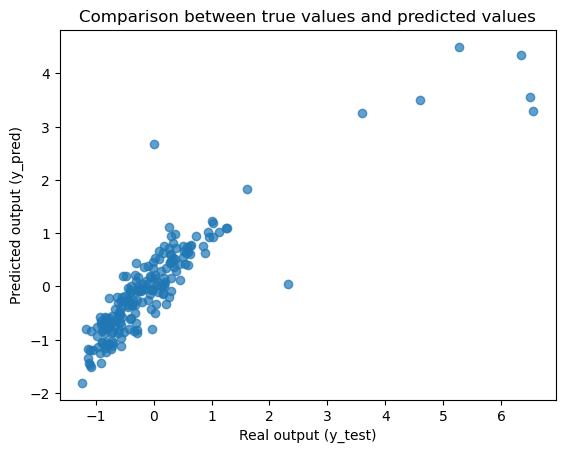

In [966]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Real output (y_test)')
plt.ylabel('Predicted output (y_pred)')
plt.title('Comparison between true values and predicted values')
plt.show()


In [967]:
# compute influence of each observation
influence = linear_model.get_influence()

# standardized residuals
standardized_residuals = influence.resid_studentized_internal

# Leverage (hat values)
leverage = influence.hat_matrix_diag

# Cook's Distance
cooks_distance = influence.cooks_distance[0]

# DFFITS
dffits = influence.dffits[0]

# DataFrame which contains the diagnostic measures
diagnostics = pd.DataFrame({
    'Standardized_Residuals': standardized_residuals,
    'Leverage': leverage,
    'Cooks_Distance': cooks_distance,
    'DFFITS': dffits
})

# Plot the diagnostics
print(diagnostics.head())

   Standardized_Residuals  Leverage  Cooks_Distance    DFFITS
0               -1.526987  0.023374        0.003720 -0.236438
1                0.025252  0.032284        0.000001  0.004609
2               -0.212360  0.009810        0.000030 -0.021124
3                1.104580  0.031046        0.002606  0.197746
4                1.090910  0.015096        0.001216  0.135077


In [968]:
# threshold
threshold_std_resid = 3
threshold_leverage = 2 * (X_train_sm.shape[1] + 1) / X_train_sm.shape[0]
threshold_cooks = 4 / X_train_sm.shape[0]
threshold_dffits = 2 * np.sqrt((X_train_sm.shape[1] + 1) / X_train_sm.shape[0])

# identify outliers
outliers = diagnostics[
    (diagnostics['Standardized_Residuals'].abs() > threshold_std_resid) |
    (diagnostics['Leverage'] > threshold_leverage) |
    (diagnostics['Cooks_Distance'] > threshold_cooks) |
    (diagnostics['DFFITS'].abs() > threshold_dffits)]

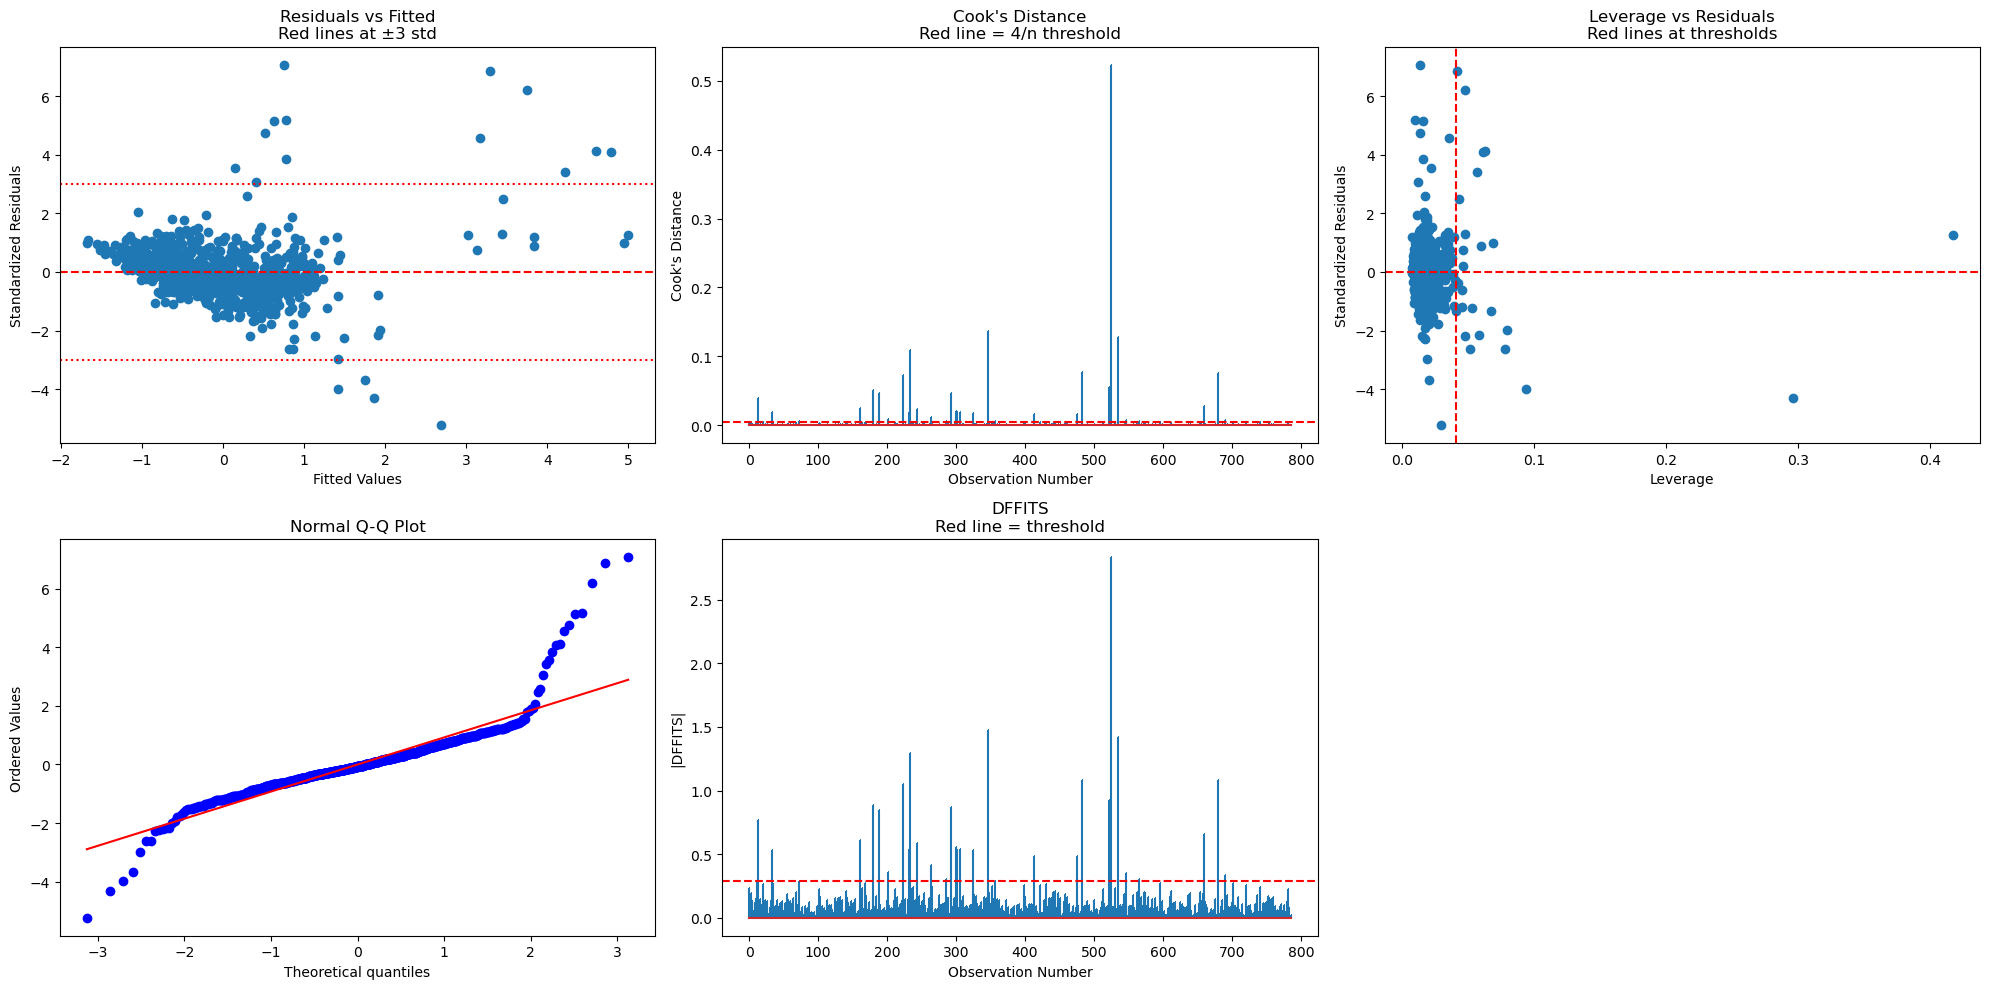

In [969]:
# Create diagnostic plots
fig = plt.figure(figsize=(20, 10))

# 1. Standardized Residuals vs Fitted Values
plt.subplot(231)
plt.scatter(linear_model.fittedvalues, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='r', linestyle=':')
plt.axhline(y=-3, color='r', linestyle=':')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Fitted\nRed lines at ±3 std')

# 2. Cook's Distance Plot
plt.subplot(232)
plt.stem(range(len(cooks_distance)), cooks_distance, markerfmt=',')
plt.axhline(y=threshold_cooks, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance\nRed line = 4/n threshold")

# 3. Leverage vs Standardized Residuals
plt.subplot(233)
plt.scatter(leverage, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=threshold_leverage, color='r', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs Residuals\nRed lines at thresholds')

# 4. QQ Plot
plt.subplot(234)
stats.probplot(standardized_residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

# 5. DFFITS Plot
plt.subplot(235)
plt.stem(range(len(dffits)), np.abs(dffits), markerfmt=',')
plt.axhline(y=threshold_dffits, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel('|DFFITS|')
plt.title('DFFITS\nRed line = threshold')

plt.tight_layout()
plt.show()


In [970]:
# observations with high leverage
high_leverage_points = diagnostics[diagnostics['Leverage'] > (2 * X_train_sm.shape[1] / X_train_sm.shape[0])]

# observations with high Cook's Distance
high_cooks_distance_points = diagnostics[diagnostics['Cooks_Distance'] > 1]

# observations with high DFFITS
threshold_dffits = 2 * ((X_train_sm.shape[1] / X_train_sm.shape[0]) ** 0.5)
high_dffits_points = diagnostics[abs(diagnostics['DFFITS']) > threshold_dffits]

# Show influential points
print("Punti con alto leverage:\n", high_leverage_points)
print("\nPunti con alta Cook's Distance:\n", high_cooks_distance_points)
print("\nPunti con alto DFFITS:\n", high_dffits_points)


Punti con alto leverage:
      Standardized_Residuals  Leverage  Cooks_Distance    DFFITS
13                -2.628228  0.078158        0.039044 -0.768233
20                -1.202461  0.045623        0.004608 -0.262983
72                -1.227497  0.053189        0.005643 -0.291034
132               -0.622974  0.045106        0.001222 -0.135343
161               -2.619466  0.051138        0.024653 -0.610439
188                3.416819  0.056787        0.046859  0.844255
201               -1.327691  0.067377        0.008490 -0.357039
223                4.088089  0.061089        0.072492  1.053581
231               -2.160185  0.058055        0.019174 -0.537571
233               -3.984206  0.093784        0.109518 -1.294269
236               -1.170284  0.039022        0.003708 -0.235881
243               -1.989101  0.079600        0.022812 -0.586084
301                2.492177  0.043492        0.018827  0.533229
346                6.877424  0.041421        0.136257  1.474654
357           

In [971]:
# Delete outliers from the training set
print(len(outliers))

print(outliers.index)

40
Index([ 12,  13,  20,  33,  72, 132, 161, 179, 188, 201, 223, 231, 233, 243,
       264, 286, 292, 300, 301, 305, 324, 346, 357, 413, 430, 474, 476, 483,
       485, 522, 525, 535, 547, 565, 596, 660, 680, 690, 752, 781],
      dtype='int64')


In [972]:
# Remove outliers from the original dataset or from its copy
df_model_cleaned = df_model_scaled.drop(index=outliers_indexes)

df_model_cleaned.shape

df_model_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           943 non-null    float64
 1   Passenger_Count            943 non-null    float64
 2   Base_Fare                  943 non-null    float64
 3   Per_Km_Rate                943 non-null    float64
 4   Per_Minute_Rate            943 non-null    float64
 5   Trip_Duration_Minutes      943 non-null    float64
 6   Trip_Price                 943 non-null    float64
 7   Time_of_Day_Evening        943 non-null    bool   
 8   Time_of_Day_Morning        943 non-null    bool   
 9   Time_of_Day_Night          943 non-null    bool   
 10  Day_of_Week_Weekend        943 non-null    bool   
 11  Traffic_Conditions_Low     943 non-null    bool   
 12  Traffic_Conditions_Medium  943 non-null    bool   
 13  Weather_Rain               943 non-null    bool   
 14 

In [973]:
X = df_model_cleaned.drop('Trip_Price', axis=1)
y = df_model_cleaned['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     168.1
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          1.48e-218
Time:                        12:59:06   Log-Likelihood:                -485.71
No. Observations:                 754   AIC:                             1001.
Df Residuals:                     739   BIC:                             1071.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

In [975]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
#print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error: 0.2735
R-squared: 0.7610


In [976]:
# Get residuals and fitted values
residuals = linear_model.resid
fitted_values = linear_model.fittedvalues

Text(0.5, 1.0, 'Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

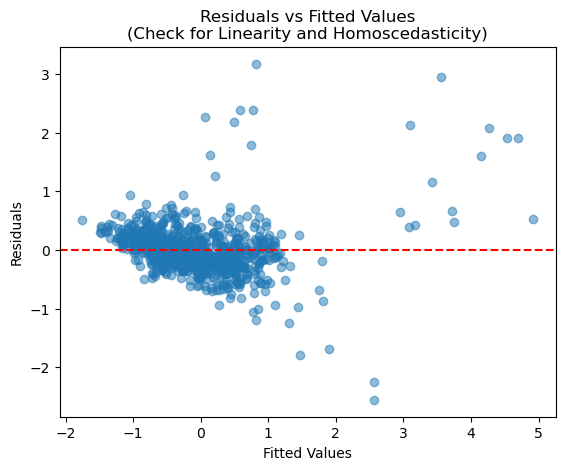

In [977]:
# 1. Residuals vs Fitted Values
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

Text(0.5, 1.0, 'Q-Q Plot\n(Check for Normality of Residuals)')

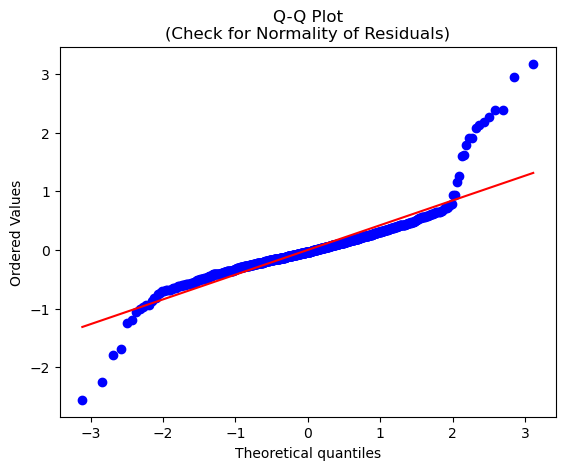

In [978]:
# 2. Q-Q Plot for Normality
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot\n(Check for Normality of Residuals)')

Text(0.5, 1.0, 'Histogram of Residuals\n(Check for Normality)')

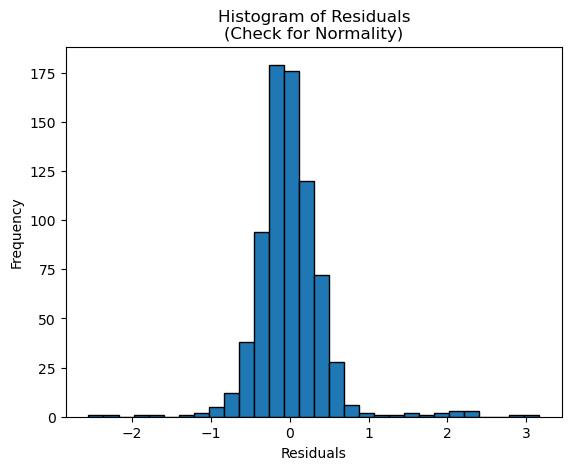

In [979]:
# 3. Residuals Histogram
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals\n(Check for Normality)')

Text(0.5, 1.0, 'Correlation Heatmap\n(Check for Multicollinearity)')

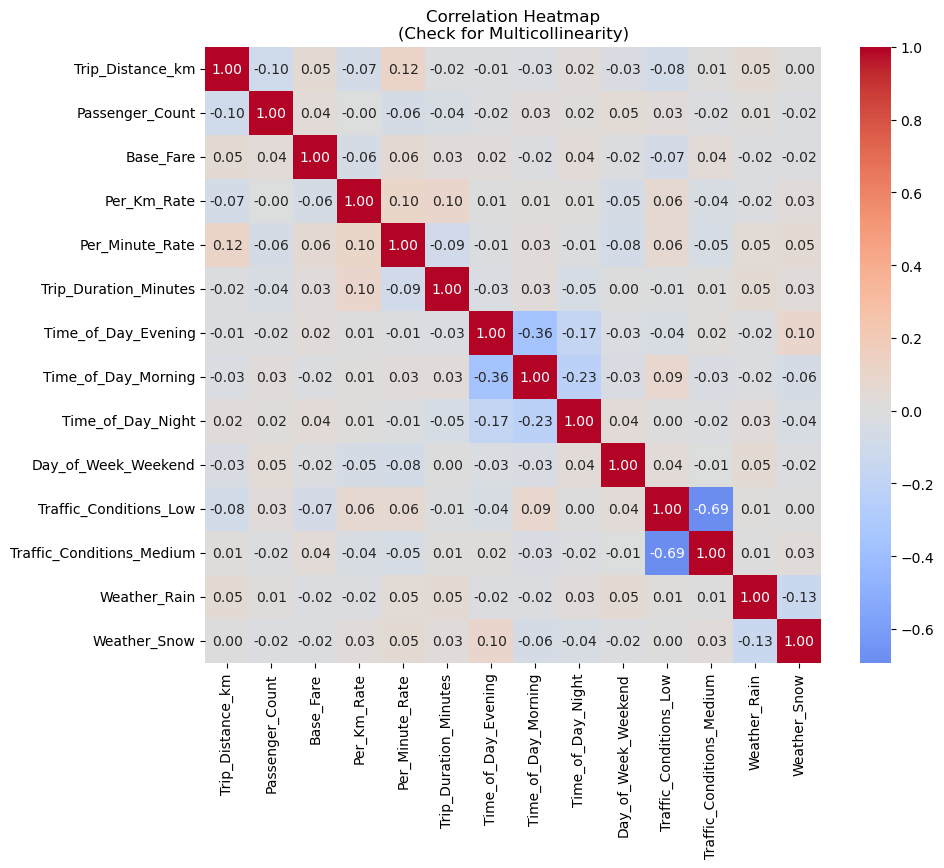

In [980]:
# 4. Correlation Heatmap
import seaborn as sns
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
plt.title('Correlation Heatmap\n(Check for Multicollinearity)')

### BEST SUBSET SELECTION

In [981]:
from itertools import combinations
import statsmodels.api as sm
import numpy as np

we check that the df_model_scaled is the full dataset with dummies and with scaled numerical variables

In [982]:
df_model_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           983 non-null    float64
 1   Passenger_Count            983 non-null    float64
 2   Base_Fare                  983 non-null    float64
 3   Per_Km_Rate                983 non-null    float64
 4   Per_Minute_Rate            983 non-null    float64
 5   Trip_Duration_Minutes      983 non-null    float64
 6   Trip_Price                 983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [984]:
X = df_model_scaled.drop('Trip_Price', axis=1)
y = df_model_scaled['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assicurati che X_train_sm e y_train abbiano gli stessi indici
X_train = X_train.loc[y_train.index]

n_features = X_train.shape[1]
best_models = {}

for k in range(1, n_features + 1):
    best_score = -np.inf
    best_combo = None
    best_model = None

    # Get all possible combinations of k features
    for combo in combinations(range(n_features), k):
        # Get the features for this combination
        X_subset = X_train.iloc[:, list(combo)]

        # Add constant
        X_subset = sm.add_constant(X_subset)

        # Assicurati che gli indici siano allineati
        X_subset = X_subset.loc[y_train.index]

        # Fit model
        model = sm.OLS(y_train, X_subset).fit()

        # Calculate adjusted R-squared
        score = model.rsquared_adj

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    # Store best model for this number of features
    best_models[k] = {
        'features': [X_train_sm.columns[i] for i in best_combo],
        'model': best_model,
        'adj_r2': best_score,
        'aic': best_model.aic,
        'bic': best_model.bic
    }

    print(f"\nBest model with {k} features:")
    print(f"Features: {best_models[k]['features']}")
    print(f"Adjusted R-squared: {best_score:.4f}")
    print(f"AIC: {best_model.aic:.4f}")
    print(f"BIC: {best_model.bic:.4f}")



Best model with 1 features:
Features: ['Trip_Distance_km']
Adjusted R-squared: 0.6316
AIC: 1379.7492
BIC: 1389.0831

Best model with 2 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate']
Adjusted R-squared: 0.7225
AIC: 1158.0636
BIC: 1172.0645

Best model with 3 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7519
AIC: 1071.0160
BIC: 1089.6838

Best model with 4 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7628
AIC: 1036.5276
BIC: 1059.8624

Best model with 5 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7700
AIC: 1013.4402
BIC: 1041.4419

Best model with 6 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Day_of_Week_Weekend']
Adjusted R-squared: 0.7704
AIC: 1013.0070
BIC: 1045.6757

Best

In [985]:
#X_train_sm.drop('const', axis=1)

X_train= X_train.loc[y_train.index]

n_features = X_train.shape[1]

best_models = {}

from itertools import combinations

for k in range(1, n_features + 1):
    best_score = -np.inf
    best_combo = None
    best_model = None

    # Get all possible combinations of k features
    for combo in combinations(range(n_features), k):
        # Get the features for this combination
        X_subset = X_train.iloc[:, list(combo)]

        # Add constant
        X_subset = sm.add_constant(X_subset)

        # Fit model
        model = sm.OLS(y_train, X_subset).fit()

        # Calculate adjusted R-squared
        score = model.rsquared_adj

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    # Store best model for this number of features
    best_models[k] = {
        'features': [X_train.columns[i] for i in best_combo],
        'model': best_model,
        'adj_r2': best_score,
        'aic': best_model.aic,
        'bic': best_model.bic
    }

    print(f"\nBest model with {k} features:")
    print(f"Features: {best_models[k]['features']}")
    print(f"Adjusted R-squared: {best_score:.4f}")
    print(f"AIC: {best_model.aic:.4f}")
    print(f"BIC: {best_model.bic:.4f}")


Best model with 1 features:
Features: ['Trip_Distance_km']
Adjusted R-squared: 0.6316
AIC: 1379.7492
BIC: 1389.0831

Best model with 2 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate']
Adjusted R-squared: 0.7225
AIC: 1158.0636
BIC: 1172.0645

Best model with 3 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7519
AIC: 1071.0160
BIC: 1089.6838

Best model with 4 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7628
AIC: 1036.5276
BIC: 1059.8624

Best model with 5 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7700
AIC: 1013.4402
BIC: 1041.4419

Best model with 6 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Day_of_Week_Weekend']
Adjusted R-squared: 0.7704
AIC: 1013.0070
BIC: 1045.6757

Best

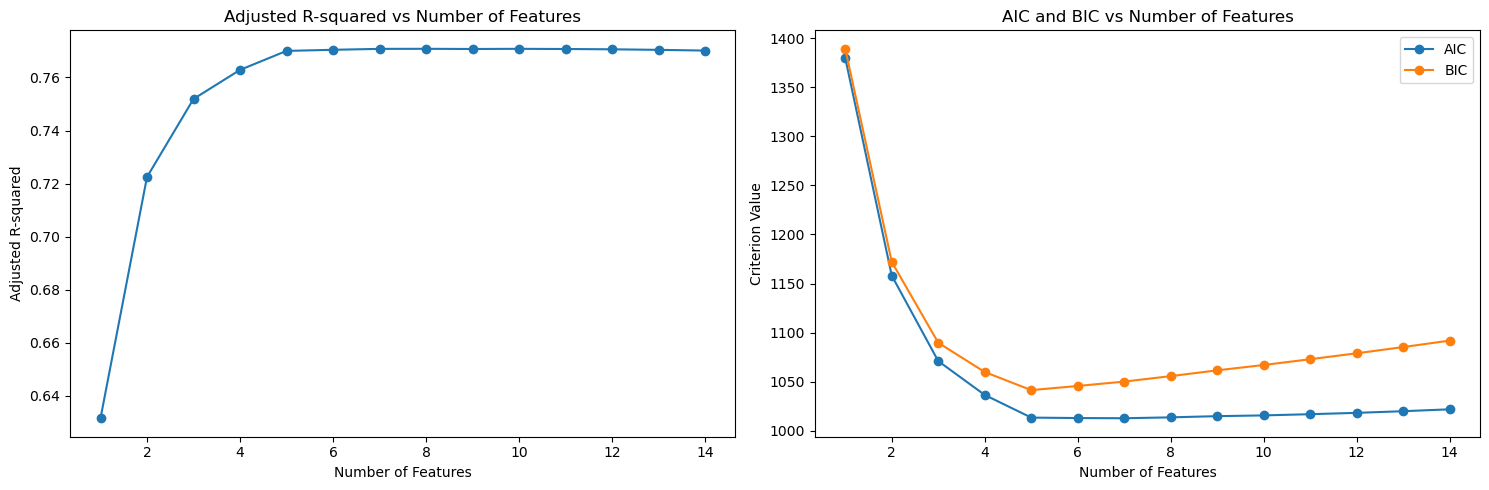

In [986]:
n_features = list(best_models.keys())
adj_r2 = [model['adj_r2'] for model in best_models.values()]
aic = [model['aic'] for model in best_models.values()]
bic = [model['bic'] for model in best_models.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Adjusted R-squared
ax1.plot(n_features, adj_r2, marker='o')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Adjusted R-squared')
ax1.set_title('Adjusted R-squared vs Number of Features')

# Plot AIC and BIC
ax2.plot(n_features, aic, marker='o', label='AIC')
ax2.plot(n_features, bic, marker='o', label='BIC')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Criterion Value')
ax2.set_title('AIC and BIC vs Number of Features')
ax2.legend()

plt.tight_layout()
plt.show()

In [988]:
# Best model chosen based on BIC
best_bic = float('inf')
best_model_key = None

for k, model_info in best_models.items():
    if model_info['bic'] < best_bic:
        best_bic = model_info['bic']
        best_model_key = k
    
best_model_info = best_models[best_model_key]
best_model = best_model_info['model']
selected_features = best_model_info['features']

print("\n=== Best Model based on BIC ===")
print(f"Number of features: {best_model_key}")
print(f"Selected features: {selected_features}")
print(f"Adjusted R²: {best_model_info['adj_r2']:.4f}")
print(f"AIC: {best_model_info['aic']:.4f}")
print(f"BIC: {best_model_info['bic']:.4f}")

# Testing the model performance
X_test_subset = X_test[selected_features]  #select the same features
X_test_subset = sm.add_constant(X_test_subset)  # add intercept
y_pred = best_model.predict(X_test_subset)

# Compute performance on test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Performance on Test Set ===")
print(f"Mean Squared Error: {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# print coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features,
    'Coefficient': best_model.params.values
})

# order coefficients
#coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("\n=== Coefficienti of best model based on BIC  ===")
print(coef_df)



=== Best Model based on BIC ===
Number of features: 5
Selected features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R²: 0.7700
AIC: 1013.4402
BIC: 1041.4419

=== Performance on Test Set ===
Mean Squared Error: 0.2705
R-squared: 0.7972

=== Coefficienti of best model based on BIC  ===
                 Feature  Coefficient
0              Intercept    -0.002904
1       Trip_Distance_km     0.800681
2        Passenger_Count     0.081688
3            Per_Km_Rate     0.255183
4        Per_Minute_Rate     0.103042
5  Trip_Duration_Minutes     0.177274


In [989]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

#Find the best model based on Adjusted R²
best_model_key = max(best_models, key=lambda k: best_models[k]['adj_r2'])
best_model_info = best_models[best_model_key]
best_model = best_model_info['model']
selected_features = best_model_info['features']

print("\n=== Best model based on Adjusted R2 ===")
print(f"Number of features: {best_model_key}")
print(f"Selected features: {selected_features}")
print(f"Adjusted R²: {best_model_info['adj_r2']:.4f}")
print(f"AIC: {best_model_info['aic']:.4f}")
print(f"BIC: {best_model_info['bic']:.4f}")

# Testing the model
X_test_subset = X_test[selected_features]  # Seleziona le stesse feature nel test set
X_test_subset = sm.add_constant(X_test_subset)  # Aggiunge l'intercetta
y_pred = best_model.predict(X_test_subset)

# Compute performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Performance on Test Set ===")
print(f"Mean Squared Error: {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

#Print coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features,
    'Coefficient': best_model.params.values
})

# Ordina i coefficienti in ordine decrescente (opzionale)
#coef_df = coef_df.sort_values(by='Coefficient', ascending=True)

print("\n=== Coefficienti del Modello Migliore ===")
print(coef_df)



=== Best model based on Adjusted R2 ===
Number of features: 8
Selected features: ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Day_of_Week_Weekend', 'Weather_Rain']
Adjusted R²: 0.7708
AIC: 1013.7021
BIC: 1055.7047

=== Performance on Test Set ===
Mean Squared Error: 0.2773
R-squared: 0.7922

=== Coefficienti del Modello Migliore ===
                 Feature  Coefficient
0              Intercept    -0.006090
1       Trip_Distance_km     0.802613
2        Passenger_Count     0.082238
3              Base_Fare    -0.017063
4            Per_Km_Rate     0.254800
5        Per_Minute_Rate     0.106132
6  Trip_Duration_Minutes     0.178032
7    Day_of_Week_Weekend     0.057731
8           Weather_Rain    -0.058676


### ELASTIC NET REGRESSION

In [990]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


In [991]:
df_model_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           983 non-null    float64
 1   Passenger_Count            983 non-null    float64
 2   Base_Fare                  983 non-null    float64
 3   Per_Km_Rate                983 non-null    float64
 4   Per_Minute_Rate            983 non-null    float64
 5   Trip_Duration_Minutes      983 non-null    float64
 6   Trip_Price                 983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [992]:
X = df_model_scaled.drop('Trip_Price', axis=1)
y = df_model_scaled['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split the  dataset (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### elastic net with parameters found by cross-validation 

In [994]:
from sklearn.linear_model import ElasticNetCV

# Create and train the ElasticNetCV model with cross-validation
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)  # cv=5 for 5-fold cross-validation
elastic_net_cv.fit(X_train, y_train)

# Coefficients of the final model
intercept = elastic_net_cv.intercept_
coefficients = elastic_net_cv.coef_

# Create a DataFrame to display the coefficients
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Sort the coefficients in descending order (optional)
#coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# # Print the results of the model
print("\n=== ElasticNet Model Summary ===")
print(f"Best alpha: {elastic_net_cv.alpha_}")
print(f"Best L1 Ratio (Mix Lasso-Ridge): {elastic_net_cv.l1_ratio_}")
print(f"Intercept (β0): {elastic_net_cv.intercept_:.4f}\n")
print("Feature Coefficients:")
print(coeff_df)

# Make predictions on the test set
y_pred = elastic_net_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Make predictions on the test set
y_pred = elastic_net_cv.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error(test): {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")



=== ElasticNet Model Summary ===
Best alpha: 0.02942696491867543
Best L1 Ratio (Mix Lasso-Ridge): 0.5
Intercept (β0): -0.0022

Feature Coefficients:
                      Feature  Coefficient
0            Trip_Distance_km     0.771046
1             Passenger_Count     0.062334
2                   Base_Fare    -0.000707
3                 Per_Km_Rate     0.239387
4             Per_Minute_Rate     0.089944
5       Trip_Duration_Minutes     0.160670
6         Time_of_Day_Evening    -0.000000
7         Time_of_Day_Morning     0.000000
8           Time_of_Day_Night     0.000000
9         Day_of_Week_Weekend     0.000000
10     Traffic_Conditions_Low    -0.000000
11  Traffic_Conditions_Medium    -0.000000
12               Weather_Rain    -0.000000
13               Weather_Snow     0.000000

Model Performance Metrics:
Mean Squared Error(test): 0.2799
R-squared: 0.7902


## LINEAR REGRESSION CON INTERACTION TERMS

We experimented several interactions and found out that these are the most significant ones: 

* Interaction between **Trip Distance** and **Weekday**
* Interaction between **Trip Duration** and **Time of the Day**
* Interaction between **Rate per KM** and **Traffic Conditions**

In [995]:

df_model_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           983 non-null    float64
 1   Passenger_Count            983 non-null    float64
 2   Base_Fare                  983 non-null    float64
 3   Per_Km_Rate                983 non-null    float64
 4   Per_Minute_Rate            983 non-null    float64
 5   Trip_Duration_Minutes      983 non-null    float64
 6   Trip_Price                 983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [996]:
#creation of interaction terms
df_model_scaled['Distance_Weekend_Interaction'] = df_model_scaled['Trip_Distance_km'] * df_model_scaled['Day_of_Week_Weekend']
df_model_scaled['KmRate_TrafficMedium_Interaction'] = df_model_scaled['Per_Km_Rate'] * df_model_scaled['Traffic_Conditions_Medium']
df_model_scaled['KmRate_TrafficLow_Interaction'] = df_model_scaled['Per_Km_Rate'] * df_model_scaled['Traffic_Conditions_Low']
df_model_scaled['Duration_Snow_Interaction'] = df_model_scaled['Trip_Duration_Minutes'] * df_model_scaled['Weather_Snow']
df_model_scaled['Duration_Rain_Interaction'] = df_model_scaled['Trip_Duration_Minutes'] * df_model_scaled['Weather_Rain']


df_model_scaled

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow,Distance_Weekend_Interaction,KmRate_TrafficMedium_Interaction,KmRate_TrafficLow_Interaction,Duration_Snow_Interaction,Duration_Rain_Interaction
0,-0.384010,0.464675,0.068663,-0.932882,0.030864,-0.284220,-0.512605,False,True,False,False,True,False,False,False,-0.000000,-0.000000,-0.932882,-0.0,-0.000000
1,1.016358,-1.384620,-0.001441,-1.312272,0.470506,-0.652917,-0.675288,False,False,False,False,False,False,False,False,0.000000,-0.000000,-0.000000,-0.0,-0.000000
2,0.484773,-1.384620,-0.944981,-0.068714,-0.648582,-0.744743,-0.111935,True,False,False,True,False,False,False,False,0.484773,-0.000000,-0.000000,-0.0,-0.000000
3,0.160467,1.389323,-0.025630,-1.544122,-0.648582,1.468552,-0.507611,True,False,False,False,True,False,False,False,0.000000,-0.000000,-1.544122,0.0,0.000000
4,-0.933769,0.464675,-0.673890,-1.291195,0.030864,-1.151840,-1.009672,True,False,False,False,False,False,False,False,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,-1.071301,1.389323,-1.310365,-1.312272,0.710310,-0.157054,-0.557329,False,False,False,True,False,True,False,False,-1.071301,-1.312272,-0.000000,-0.0,-0.000000
979,0.935033,1.389323,-0.449946,-1.333350,-0.246174,-0.057714,0.110212,False,False,True,False,False,True,False,False,0.000000,-1.333350,-0.000000,-0.0,-0.000000
980,-0.961711,0.464675,-1.675748,1.132690,-0.433608,-0.274202,-0.588180,False,True,False,False,True,False,True,False,-0.000000,0.000000,1.132690,-0.0,-0.274202
981,1.014870,-1.384620,-0.980341,-0.890727,-0.568647,1.416517,0.088049,False,True,False,False,True,False,False,False,0.000000,-0.000000,-0.890727,0.0,0.000000


In [997]:
#drop the dummies to avoid replicating the same information
columns_to_drop = ['Day_of_Week_Weekend', 'Traffic_Conditions_Low', 'Traffic_Conditions_Medium','Weather_Rain','Weather_Snow']
df_model_scaled = df_model_scaled.drop(columns_to_drop, axis = 1)

In [998]:
# split the variables into predictors X (features) e y (target)
X = df_model_scaled.drop('Trip_Price', axis=1)
y = df_model_scaled['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)
X_train_sm = X_train_sm.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     195.5
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          2.43e-242
Time:                        13:11:19   Log-Likelihood:                -485.38
No. Observations:                 786   AIC:                             1001.
Df Residuals:                     771   BIC:                             1071.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

## Intepretation of the INTERACTION TERMS

1) **KmRate_TrafficLow_Interaction** relative to the baseline *Traffic_Conditions_High*:

Traffic_Conditions_Low = 1 indicates low traffic conditions (compared to high).
The KmRate_TrafficLow_Interaction coefficient (β = -0.0841) represents the change in the effect of Per_Km_Rate when moving from high to low traffic.

Specifically:
* In high traffic conditions (baseline), the effect of Per_Km_Rate is simply its main coefficient (β = 0.2864).
* In low traffic conditions, the total effect of Per_Km_Rate becomes: 0.2864 -0.0841  = 0.2023.

This means the effect of the per-km rate on price is lower in low traffic compared to high traffic conditions.
In other words, when there is light traffic, the impact of the per-km rate on the final price is significantly reduced relative to heavy traffic. This could reflect a pricing strategy that accounts for greater operational efficiency in low traffic situations.

2. **Distance_Weekend_Interaction** relative to the baseline *Day_of_Week_Weekend*:

Specifically:
* The main variable Trip_Distance_km has a coefficient of β = 0.8213  .
* Weekend = 1 represents weekend trips (compared to weekdays). The Distance_Weekend_Interaction coefficient (β = -0.0597) represents the change in the effect of Distance on price when the trip is done on the weekend. 

**In weekdays** (baseline): The effect of distance is given by the main coefficient: β = 0.8213. This means a 1 standard deviation increase in distance increases price by 0.8213 standard deviations.
**On weekends**: The total effect of distance on price becomes: 0.8213 -0.0597 = 0.7616. This means the effect of distance on price is lower on weekends compared to weekdays.

This suggests a *pricing policy* where the per-kilometer rate has a smaller impact on the final price during weekends. 
This could reflect factors like:
- Lower road congestion on weekends
- Differentiated pricing strategies to stimulate weekend demand
- Greater operational efficiency on non-workdays

3. **Duration_Rain_Interaction** relative to the baseline *Weather_Sun*:

Specifically:
* The main variable Trip_Duration_Minutes has a coefficient of β = 0.2230 .
* Weather_Rain = 1 represents trips whith rainy weather conditions (compared to weekdays). The Duration_Rain_Interaction coefficient (β =  -0.1326 ) represents the change in the effect of Duration_Minutes on price when the trip is done whith rainy weather conditions. 

**On sunny days** (baseline): The effect of distance is given by the main coefficient: β = 0.2230. This means a 1 standard deviation increase in Minutes Duration increases price by 0.2230 standard deviations.
**On rainy days**: The total effect of duration on price becomes: 0.2230  -0.1326  = 0.0904. This means the effect of distance on price is lower on rainy days compared to sunny days.

What can be the economical explanation?
In rainy conditions, operating costs and travel times tend to increase. As a result, transportation service providers may apply a pricing policy that reduces the impact of distance on the final price, in order to avoid excessively penalizing the end customer due to external factors.
The idea is that in adverse weather conditions, the service provider is willing to absorb a portion of the higher costs associated with distance, in order to keep the service accessible and competitive. This could reflect a business strategy aimed at preventing customers from being discouraged from booking a trip due to a too-high price increase caused by rain.
Therefore, from the customer's perspective, the final price will be less sensitive to the distance traveled when it rains, as the service provider amortizes part of this additional cost. This can be interpreted as a mechanism to shield customers from the risks associated with weather conditions.

In [999]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error(test): {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
#print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error(test): 0.2782
R-squared: 0.7802
